In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ratinabox.Environment import Environment

from models import *
from data_generation import *

/Users/frederikrogge/miniforge3/envs/bsr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create environment

(-0.9090268141605715,
 1.232267022350515,
 -1.6334179368020911,
 0.9803024699796475)

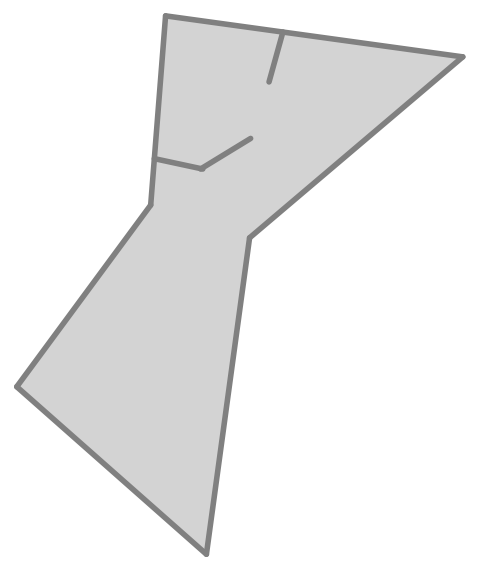

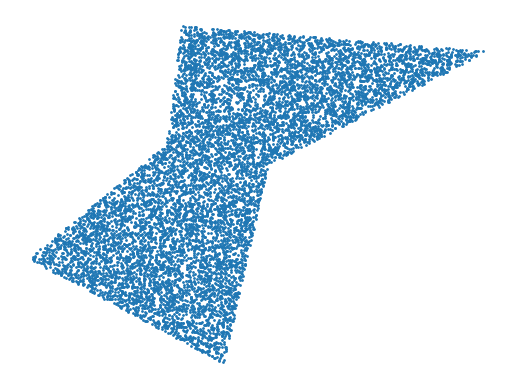

In [12]:
# Create environment
# env = Environment({'boundary': [[1, 1], [0, 0.1], [0, 0.8]]})
env = generate_random_polygon_env()
env = add_random_walls(env, n_walls=3)
env.plot_environment()

samples = generate_random_samples(env, 10000)

fig, ax = plt.subplots()
ax.scatter(samples[:,0], samples[:,1], s=1)
ax.axis('off')

### Train model

In [13]:
train_steps = 5000      # number of training steps
scale = 0.1             # scale of the correlation function
nr = 100                # no. of spatial representations
bs = 512                # batch size

# Create model and optimizer
model = SpaceNet(nr)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Reset gradients
    optimizer.zero_grad()

    # Generate batch of random samples
    r = torch.Tensor(generate_random_samples(env, bs).astype('float32'))

    # Get predictions
    p, corr = model(r)

    # Compute distance
    d = torch.sum((r[:,None] - r[None])**2, dim=-1)

    # Compute loss
    correlation_loss = (corr - torch.exp((-0.5 / (scale**2)) * d))**2
    loss = torch.mean(correlation_loss)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        loss = loss.item()
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.003984: 100%|██████████| 5000/5000 [02:22<00:00, 35.15it/s]


### Evaluate model on all positions in the environment

In [4]:
# Sample points
nx, ny = 64, 64
x = np.linspace(env.extent[0], env.extent[1], nx)
y = np.linspace(env.extent[2], env.extent[3], ny)
xx, yy = np.meshgrid(x,y)
u = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype('float32')

# Output of last layer
p, pcorr = model(torch.tensor(u))

# Hidden layer output
hidden_p = model.hidden_output(torch.tensor(u))

# Convert to numpy arrays
p = p.detach().numpy()
pcorr = pcorr.detach().numpy()
hidden_p = hidden_p.detach().numpy()

Text(0, 0.5, 'Train Loss')

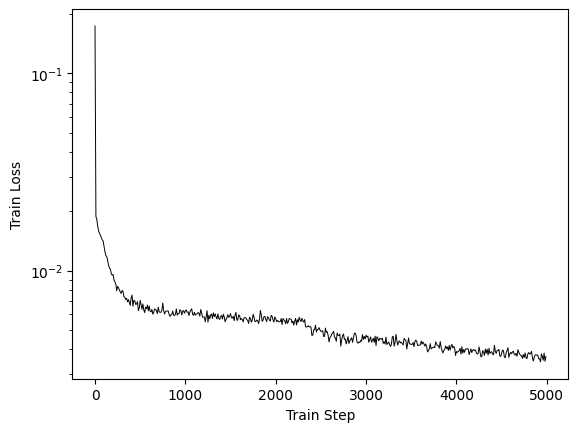

In [5]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

### Create a mask indicating whether a position is in the environment

In [6]:
# Get mask of positions that are in or out of the environment
pos_mask = np.ones(p.shape[0], dtype=bool)
for i, _p in enumerate(u):
    if not env.check_if_position_is_in_environment(_p):
        pos_mask[i] = False
pos_mask = pos_mask.reshape(nx, ny)

### Find the maximum activation for each unit

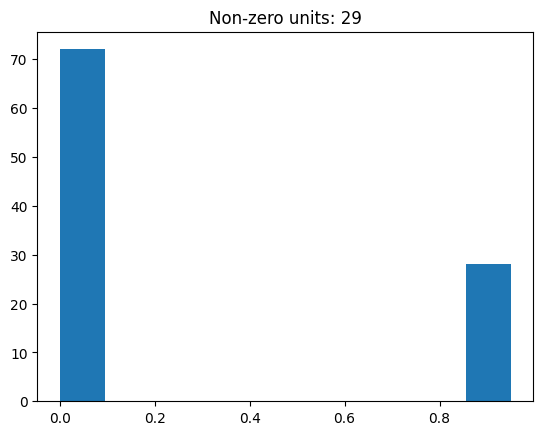

In [7]:
# select units nonzero activity
max_ind = np.argmax(p, axis = 0)
max_loc = u[max_ind]
mask = np.array([p[ind, i] > 0 for i, ind in enumerate(max_ind)])
nonzero_max_loc = max_loc[mask]

p[:,mask].shape
plt.hist(np.amax(p, axis = 0))
plt.title(f"Non-zero units: {mask.sum()}")
plt.show()

### Plot the spatial representations

#### Output layer

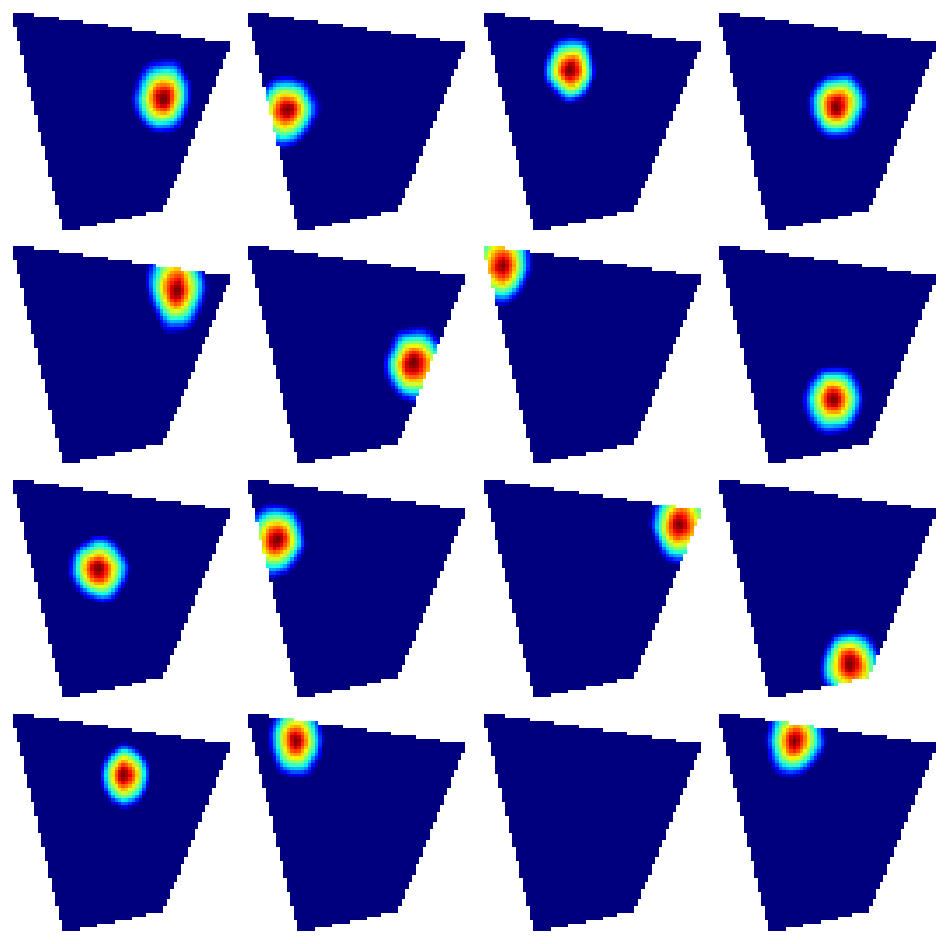

In [8]:
n_p = 4
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[mask][:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(nx, ny)
    representation[~pos_mask] = np.nan

    ax[row, col].imshow(representation, cmap = "jet")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

#### Hidden layer

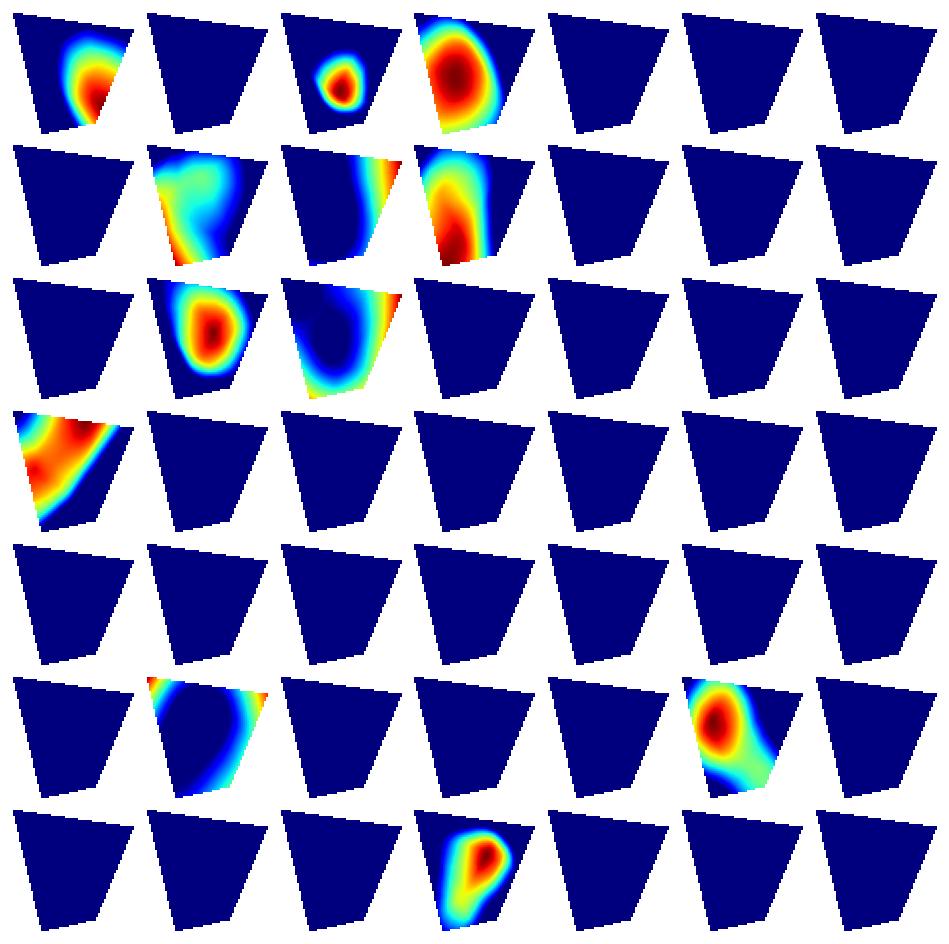

In [9]:
n_p = 7
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(hidden_p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(nx, ny)
    representation[~pos_mask] = np.nan

    ax[row, col].imshow(representation, cmap = "jet")

plt.subplots_adjust(wspace=0.05, hspace=0.05)